## HORUS-NER: Text Classification (v1.0)

## Get training data from DBPedia

In [78]:
import requests
import json
import csv
import pandas as pd
import io
from SPARQLWrapper import SPARQLWrapper, JSON, CSV, TSV
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from IPython.display import display
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Defining SPARQL queries

In [25]:
endpoint = 'https://dbpedia.org/sparql'

query_sufix = """
offset <offset>
limit 10000
"""
query_namespaces = """
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

"""
query_per = """
SELECT ?s, ?label, dbo:Person as ?type, ?abstract
FROM <http://dbpedia.org>
WHERE {
    ?s rdf:type dbo:Person .
    ?s rdfs:label ?label .
    ?s dbo:abstract ?abstract .
    FILTER (lang(?label) = 'en') .
    FILTER (lang(?abstract) = 'en')
}
"""

query_loc = """
SELECT ?s, ?label, ?type, ?abstract
FROM <http://dbpedia.org>
WHERE {
    ?s rdf:type ?type . 
    ?s rdfs:label ?label .
    ?s dbo:abstract ?abstract .
    FILTER (lang(?abstract) = 'en')
    FILTER (lang(?label) = 'en')
    FILTER (?type IN (dbo:City, dbo:Country, dbo:Towns, dbo:Municipality, dbo:Hill_station, dbo:Village, dbo:Suburb, dbo:Neighborhood, dbo:NaturalPlace, dbo:Urban_areas, dbo:Tourist_attraction)) 
}
"""

query_org = """
SELECT ?s, ?label, ?type, ?abstract
FROM <http://dbpedia.org>
WHERE { ?s rdf:type ?type .
        ?s rdfs:label ?label .
        ?s dbo:abstract ?abstract .
    FILTER (lang(?abstract) = 'en')
    FILTER (lang(?label) = 'en')
    FILTER (?type IN (dbo:Organisation, dbo:Company)) 
}
"""    

query_others = """
SELECT ?s, ?label, ?type, ?abstract
FROM <http://dbpedia.org>
WHERE {
    ?s rdf:type ?type . 
    ?s rdfs:label ?label .
    ?s dbo:abstract ?abstract .
    FILTER (lang(?abstract) = 'en')
    FILTER (lang(?label) = 'en')
    FILTER (?type IN (dbo:WrittenWork, dbo:Species, dbo:CelestialBody, dbo:Food, dbo:Disease, dbo:Game, dbo:MeanOfTransportation)) 
}
"""

## Saving data from DBPedia

In [26]:
# limit is fixed to its default: 10000
offsets = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]

sparql = SPARQLWrapper("http://dbpedia.org/sparql")
Q = [('person', query_per), ('location', query_loc), ('organisation', query_org), ('other', query_others)]
for (label, query) in Q:
    for offset in offsets:
        print(label, offset)
        file_sufix = '0' + str(offset)[0]
        if len(str(offset))==6: 
            file_sufix = str(offset)[0:2]
        path = f'./data/raw/dump_dbpedia_{label}_{file_sufix}.csv'
        if not os.path.isfile(path):
            sparql.setQuery(query_namespaces + query + query_sufix.replace('<offset>', str(offset)))
            sparql.setReturnFormat(TSV)
            results = sparql.query().convert()
            df = pd.read_csv(io.BytesIO(results), sep="\t") 
            df.to_csv(path, sep='\t')

person 0
person 10000
person 20000
person 30000
person 40000
person 50000
person 60000
person 70000
person 80000
person 90000
person 100000
location 0
location 10000
location 20000
location 30000
location 40000
location 50000
location 60000
location 70000
location 80000
location 90000
location 100000
organisation 0
organisation 10000
organisation 20000
organisation 30000
organisation 40000
organisation 50000
organisation 60000
organisation 70000
organisation 80000
organisation 90000
organisation 100000
other 0
other 10000
other 20000
other 30000
other 40000
other 50000
other 60000
other 70000
other 80000
other 90000
other 100000


In [27]:
df_per0 = pd.read_csv('./data/raw/dump_dbpedia_person_00.csv', sep='\t', index_col=0)
df_per1 = pd.read_csv('./data/raw/dump_dbpedia_person_01.csv', sep='\t', index_col=0)
"""
df_per2 = pd.read_csv('./data/raw/dump_dbpedia_person_02.csv', sep='\t', index_col=0)
df_per3 = pd.read_csv('./data/raw/dump_dbpedia_person_03.csv', sep='\t', index_col=0)
df_per4 = pd.read_csv('./data/raw/dump_dbpedia_person_04.csv', sep='\t', index_col=0)
df_per5 = pd.read_csv('./data/raw/dump_dbpedia_person_05.csv', sep='\t', index_col=0)
df_per6 = pd.read_csv('./data/raw/dump_dbpedia_person_06.csv', sep='\t', index_col=0)
df_per7 = pd.read_csv('./data/raw/dump_dbpedia_person_07.csv', sep='\t', index_col=0)
df_per8 = pd.read_csv('./data/raw/dump_dbpedia_person_08.csv', sep='\t', index_col=0)
df_per9 = pd.read_csv('./data/raw/dump_dbpedia_person_09.csv', sep='\t', index_col=0)
df_per10 = pd.read_csv('./data/raw/dump_dbpedia_person_10.csv', sep='\t', index_col=0)
"""

df_org0 = pd.read_csv('./data/raw/dump_dbpedia_organisation_00.csv', sep='\t', index_col=0)
df_org1 = pd.read_csv('./data/raw/dump_dbpedia_organisation_01.csv', sep='\t', index_col=0)
"""
df_org2 = pd.read_csv('./data/raw/dump_dbpedia_organisation_02.csv', sep='\t', index_col=0)
df_org3 = pd.read_csv('./data/raw/dump_dbpedia_organisation_03.csv', sep='\t', index_col=0)
df_org4 = pd.read_csv('./data/raw/dump_dbpedia_organisation_04.csv', sep='\t', index_col=0)
df_org5 = pd.read_csv('./data/raw/dump_dbpedia_organisation_05.csv', sep='\t', index_col=0)
df_org6 = pd.read_csv('./data/raw/dump_dbpedia_organisation_06.csv', sep='\t', index_col=0)
df_org7 = pd.read_csv('./data/raw/dump_dbpedia_organisation_07.csv', sep='\t', index_col=0)
df_org8 = pd.read_csv('./data/raw/dump_dbpedia_organisation_08.csv', sep='\t', index_col=0)
df_org9 = pd.read_csv('./data/raw/dump_dbpedia_organisation_09.csv', sep='\t', index_col=0)
df_org10 = pd.read_csv('./data/raw/dump_dbpedia_organisation_10.csv', sep='\t', index_col=0)
"""

df_loc0 = pd.read_csv('./data/raw/dump_dbpedia_location_00.csv', sep='\t', index_col=0)
df_loc1 = pd.read_csv('./data/raw/dump_dbpedia_location_01.csv', sep='\t', index_col=0)
"""
df_loc2 = pd.read_csv('./data/raw/dump_dbpedia_location_02.csv', sep='\t', index_col=0)
df_loc3 = pd.read_csv('./data/raw/dump_dbpedia_location_03.csv', sep='\t', index_col=0)
df_loc4 = pd.read_csv('./data/raw/dump_dbpedia_location_04.csv', sep='\t', index_col=0)
df_loc5 = pd.read_csv('./data/raw/dump_dbpedia_location_05.csv', sep='\t', index_col=0)
df_loc6 = pd.read_csv('./data/raw/dump_dbpedia_location_06.csv', sep='\t', index_col=0)
df_loc7 = pd.read_csv('./data/raw/dump_dbpedia_location_07.csv', sep='\t', index_col=0)
df_loc8 = pd.read_csv('./data/raw/dump_dbpedia_location_08.csv', sep='\t', index_col=0)
df_loc9 = pd.read_csv('./data/raw/dump_dbpedia_location_09.csv', sep='\t', index_col=0)
df_loc10 = pd.read_csv('./data/raw/dump_dbpedia_location_10.csv', sep='\t', index_col=0)
"""
df_other0 = pd.read_csv('./data/raw/dump_dbpedia_other_00.csv', sep='\t', index_col=0)
df_other1 = pd.read_csv('./data/raw/dump_dbpedia_other_01.csv', sep='\t', index_col=0)
"""
df_other2 = pd.read_csv('./data/raw/dump_dbpedia_other_02.csv', sep='\t', index_col=0)
df_other3 = pd.read_csv('./data/raw/dump_dbpedia_other_03.csv', sep='\t', index_col=0)
df_other4 = pd.read_csv('./data/raw/dump_dbpedia_other_04.csv', sep='\t', index_col=0)
df_other5 = pd.read_csv('./data/raw/dump_dbpedia_other_05.csv', sep='\t', index_col=0)
df_other6 = pd.read_csv('./data/raw/dump_dbpedia_other_06.csv', sep='\t', index_col=0)
df_other7 = pd.read_csv('./data/raw/dump_dbpedia_other_07.csv', sep='\t', index_col=0)
df_other8 = pd.read_csv('./data/raw/dump_dbpedia_other_08.csv', sep='\t', index_col=0)
df_other9 = pd.read_csv('./data/raw/dump_dbpedia_other_09.csv', sep='\t', index_col=0)
df_other10 = pd.read_csv('./data/raw/dump_dbpedia_other_10.csv', sep='\t', index_col=0)
"""

"\ndf_other2 = pd.read_csv('./data/raw/dump_dbpedia_other_02.csv', sep='\t', index_col=0)\ndf_other3 = pd.read_csv('./data/raw/dump_dbpedia_other_03.csv', sep='\t', index_col=0)\ndf_other4 = pd.read_csv('./data/raw/dump_dbpedia_other_04.csv', sep='\t', index_col=0)\ndf_other5 = pd.read_csv('./data/raw/dump_dbpedia_other_05.csv', sep='\t', index_col=0)\ndf_other6 = pd.read_csv('./data/raw/dump_dbpedia_other_06.csv', sep='\t', index_col=0)\ndf_other7 = pd.read_csv('./data/raw/dump_dbpedia_other_07.csv', sep='\t', index_col=0)\ndf_other8 = pd.read_csv('./data/raw/dump_dbpedia_other_08.csv', sep='\t', index_col=0)\ndf_other9 = pd.read_csv('./data/raw/dump_dbpedia_other_09.csv', sep='\t', index_col=0)\ndf_other10 = pd.read_csv('./data/raw/dump_dbpedia_other_10.csv', sep='\t', index_col=0)\n"

In [28]:
df_per0.head()

,s,label,type,abstract
0,http://dbpedia.org/resource/Andreas_Ekberg,Andreas Ekberg,http://dbpedia.org/ontology/Person,Andreas Ekberg (born 2 January 1985) is a Swed...
1,http://dbpedia.org/resource/Danilo_Tognon,Danilo Tognon,http://dbpedia.org/ontology/Person,"The Canoeist Danilo Tognon (born October 9, 19..."
2,http://dbpedia.org/resource/Lorine_Livington_P...,Lorine Livington Pruette,http://dbpedia.org/ontology/Person,Lorine Livington Pruette (1896–1977) was an Am...
3,http://dbpedia.org/resource/Megan_Lawrence,Megan Lawrence,http://dbpedia.org/ontology/Person,Megan Lawrence (born 1972) is an American actr...
4,http://dbpedia.org/resource/Nikolaos_Ventouras,Nikolaos Ventouras,http://dbpedia.org/ontology/Person,"Nikos Ventouras (August 31, 1899 – April 1, 19..."


## Training data

In [29]:
#aux = [df_per0, df_per1, df_per2, df_per3, df_per4, df_per5, df_per6, df_per7, df_per8, df_per9, df_per10]
aux = [df_per0, df_per1]
df_per = pd.concat(aux)
print('PERSON', df_per.shape)
df_per.drop_duplicates(subset ="label", keep = False, inplace = True) 
print(df_per.shape)
df_per.to_csv('./data/processed/dump_dbpedia_person.csv', sep='\t')

#aux = [df_org0, df_org1, df_org2, df_org3, df_org4, df_org5, df_org6, df_org7, df_org8, df_org9, df_org10]
aux = [df_org0, df_org1]
df_org = pd.concat(aux)
print('ORGANISATION', df_org.shape)
df_org.drop_duplicates(subset ="label", keep = False, inplace = True) 
print(df_org.shape)
df_org.to_csv('./data/processed/dump_dbpedia_organisation.csv', sep='\t')

#aux = [df_loc0, df_loc1, df_loc2, df_loc3, df_loc4, df_loc5, df_loc6, df_loc7, df_loc8, df_loc9, df_loc10]
aux = [df_loc0, df_loc1]
df_loc = pd.concat(aux)
print('LOCATION', df_loc.shape)
df_loc.drop_duplicates(subset ="label", keep = False, inplace = True) 
print(df_loc.shape)
df_loc.to_csv('./data/processed/dump_dbpedia_location.csv', sep='\t')

#aux = [df_other0, df_other1, df_other2, df_other3, df_other4, df_other5, df_other6, df_other7, df_other8, df_other9, df_other10]
aux = [df_other0, df_other1]
df_other = pd.concat(aux)
print('OTHER', df_other.shape)
df_other.drop_duplicates(subset ="label", keep = False, inplace = True) 
print(df_other.shape)
df_other.to_csv('./data/processed/dump_dbpedia_other.csv', sep='\t')

PERSON (20000, 4)
(20000, 4)
ORGANISATION (20000, 4)
(12292, 4)
LOCATION (20000, 4)
(20000, 4)
OTHER (20000, 4)
(19970, 4)


In [30]:
# adding the label class
df_per['category'] = 'PER'
df_org['category'] = 'ORG'
df_loc['category'] = 'LOC'
df_other['category'] = 'OTHER'

In [31]:
training_data = [df_per, df_org, df_loc, df_other]
df_train = pd.concat(training_data, ignore_index=True, keys=["s", "label", "type", "abstract", "category"])
df_train.reset_index(drop=True)
df_train.groupby('category').s.count()

category
LOC      20000
ORG      12292
OTHER    19970
PER      20000
Name: s, dtype: int64

In [32]:
df_train['category_id'] = df_train['category'].factorize()[0]
#df_train.set_index(['s', 'y'])
#columns = ["s", "label", "type", "abstract", "y"]
#df_train = df_train.reindex(columns=columns)
#df_train[columns] = df_train[columns].astype(int)

In [10]:
category_id_df = df_train[['category', 'category_id']].drop_duplicates().sort_values('category_id')

In [11]:
category_id_df

,category,category_id
0,PER,0
20000,ORG,1
32292,LOC,2
52292,OTHER,3


In [12]:
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
df_train.head()

,s,label,type,abstract,category,category_id
0,http://dbpedia.org/resource/Andreas_Ekberg,Andreas Ekberg,http://dbpedia.org/ontology/Person,Andreas Ekberg (born 2 January 1985) is a Swed...,PER,0
1,http://dbpedia.org/resource/Danilo_Tognon,Danilo Tognon,http://dbpedia.org/ontology/Person,"The Canoeist Danilo Tognon (born October 9, 19...",PER,0
2,http://dbpedia.org/resource/Lorine_Livington_P...,Lorine Livington Pruette,http://dbpedia.org/ontology/Person,Lorine Livington Pruette (1896–1977) was an Am...,PER,0
3,http://dbpedia.org/resource/Megan_Lawrence,Megan Lawrence,http://dbpedia.org/ontology/Person,Megan Lawrence (born 1972) is an American actr...,PER,0
4,http://dbpedia.org/resource/Nikolaos_Ventouras,Nikolaos Ventouras,http://dbpedia.org/ontology/Person,"Nikos Ventouras (August 31, 1899 – April 1, 19...",PER,0


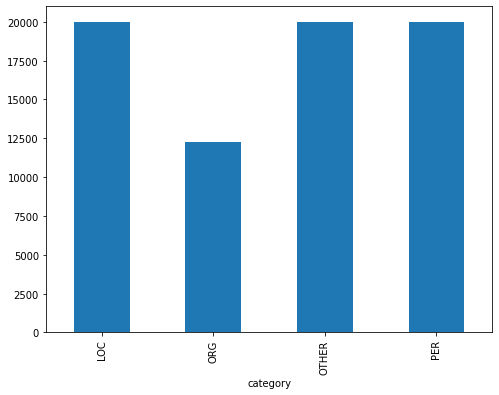

In [13]:
fig = plt.figure(figsize=(8,6))
df_train.groupby('category').label.count().plot.bar(ylim=0)
plt.show()

## Feature Extraction

In [14]:
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2), 
                        stop_words='english',
                        max_features=15000)
features = tfidf.fit_transform(df_train.abstract.astype(str)).toarray()
labels = df_train.category_id
features.shape
# total of abstracts x nr. of features per abstract

(72262, 15000)

In [15]:
N = 2
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category))
    print("  . -- Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . -- Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'LOC':
  . -- Most correlated unigrams:
. population
. city
  . -- Most correlated bigrams:
. states population
. 2010 census
# 'ORG':
  . -- Most correlated unigrams:
. band
. school
  . -- Most correlated bigrams:
. radio station
. high school
# 'OTHER':
  . -- Most correlated unigrams:
. family
. species
  . -- Most correlated bigrams:
. gastropod mollusk
. marine gastropod
# 'PER':
  . -- Most correlated unigrams:
. played
. born
  . -- Most correlated bigrams:
. states population
. 2010 census


In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_train['abstract'].astype(str), 
                                                    df_train['category'].astype(str), 
                                                    random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [17]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [18]:
type(X_train)

pandas.core.series.Series

In [19]:
print(clf.predict(count_vect.transform(["Diego was born in Mars and currently lives in Venus, which is a city."])))

['PER']


In [20]:
len(labels)

72262

## Benchmark

In [33]:
models = [
    #RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    CalibratedClassifierCV(LinearSVC()),
    #LogisticRegression(random_state=0)
    LogisticRegression(multi_class="multinomial", solver="lbfgs", C=5, random_state=0)
]
CV = 3
print(1)
cv_df = pd.DataFrame(index=range(CV * len(models)))
print(2)
entries = []
for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    print(3)
    for fold_idx, accuracy in enumerate(accuracies):
        print(4)
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

1
2
LinearSVC
3
4
4
4
CalibratedClassifierCV
3
4
4
4
LogisticRegression


/Users/diego.esteves/.local/share/virtualenvs/horus-MzGAWMx0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/diego.esteves/.local/share/virtualenvs/horus-MzGAWMx0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternat

3
4
4
4


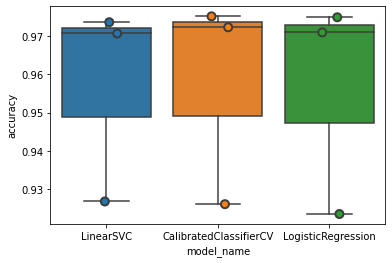

In [34]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [35]:
cv_df.groupby('model_name').accuracy.mean()

model_name
CalibratedClassifierCV    0.957848
LinearSVC                 0.957032
LogisticRegression        0.956464
Name: accuracy, dtype: float64

## Model Evaluation

In [36]:
model = CalibratedClassifierCV(LinearSVC())
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_train.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

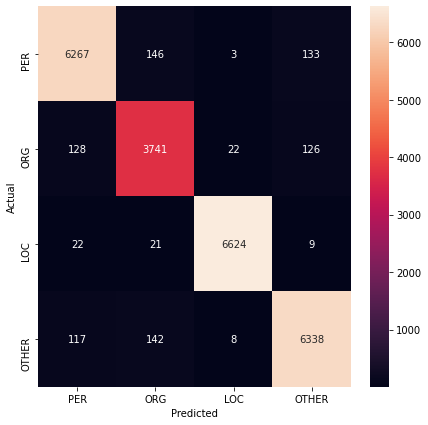

In [37]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [38]:
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df_train.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 'abstract']])
            print('')

'ORG' predicted as 'PER' : 128 examples.


,category,abstract
25532,ORG,The Bluegrass Stallions are a basketball team ...
20641,ORG,The Whig Party was a political party active i...
21111,ORG,"Alexander Mair ""Sandy"" Courage, Jr. (December ..."
30511,ORG,Mysti Mayhem (born Misty Dawn Naholnik on May ...
24901,ORG,The Alliance of the Orders of Saint John of Je...
20954,ORG,The Red Bull Drifting World Championship is a ...
21410,ORG,The Cambridge University Light Entertainment S...
20203,ORG,"In cricket, a googly (or wrong 'un) is a type ..."
20036,ORG,The Arts and Crafts movement was an internatio...
22173,ORG,Hideo Yoshizawa (吉沢 秀雄 Yoshizawa Hideo) is a v...



'LOC' predicted as 'PER' : 22 examples.


,category,abstract
34848,LOC,The 2010–11 season was Swansea City's 82nd sea...
37664,LOC,"Kuehnle's Hotel was an Atlantic City, New Jers..."
36620,LOC,"According to Imperial Gazetteer of India, Kala..."
35451,LOC,"Irará is a city in Bahia, Brazil. Irará is the..."
33044,LOC,"Anthony Robert Gizzo (August 4, 1902 – April 1..."
37825,LOC,The 1997 South American Under-17 Football Cham...
37859,LOC,Yigal Ozeri (born 1958) is an Israeli artist b...
37855,LOC,"Marvin Crenshaw (born February 3, 1952) is a f..."
37827,LOC,The 2003 South American Under-17 Football Cham...
37830,LOC,"Located on Chicago's South Side, the Velvet Lo..."



'OTHER' predicted as 'PER' : 117 examples.


,category,abstract
55097,OTHER,The Social Contract: A Personal Inquiry into t...
58270,OTHER,The Forger is a novel by Paul Watkins about a ...
58557,OTHER,The Book of the Law of the Lord is a book acce...
65404,OTHER,"(248835) 2006 SX368 /əˈkɪroʊ.iː/, also known a..."
53914,OTHER,Dara Moskowitz Grumdahl is a food and wine wri...
55413,OTHER,Impressionism is a 2009 play by Michael Jacobs...
57205,OTHER,The Save Jersey Blog is a conservative politic...
56390,OTHER,Iyyun: The Jerusalem Philosophical Quarterly (...
53608,OTHER,"""An Arundel Tomb"" is a poem by Philip Larkin, ..."
54948,OTHER,The 'Nam was a war comic book series detailing...



'PER' predicted as 'ORG' : 146 examples.


,category,abstract
16564,PER,Mert Yücel is an electronic music producer and...
13711,PER,"John Horrocks (27 March 1768, in Edgworth, Lan..."
2612,PER,Chua Beng Huat (simplified Chinese: 蔡明发; tradi...
2871,PER,Edward Michael Scheidt is a retired Chairman o...
1599,PER,"A Sikh (/siːk, sɪk/; Punjabi: ਸਿੱਖ sikkh [sɪkk..."
12985,PER,"(For other people named James Ballantyne, see ..."
17428,PER,"Nicolas Perrot (c.1644–1717), a French explore..."
18825,PER,Reginald Cheyne was the Chamberlain of Scotlan...
17771,PER,"Owsley Brown Frazier (May 7, 1935 – August 16,..."
6347,PER,BeBe & CeCe Winans are an American gospel musi...



'LOC' predicted as 'ORG' : 21 examples.


,category,abstract
37834,LOC,The 1913–14 season was the 22nd in the history...
35384,LOC,"The Louisville and Nashville Depot, located at..."
47255,LOC,Leganés (Spanish pronunciation: [le.ɣa.ˈnes]) ...
35280,LOC,Paranavaí is a city in southern Brazil that wa...
37732,LOC,Fareed Town (Urdu: فرید ٹاون‎) is a new town ...
34342,LOC,Karaparamba is a suburb included in Kozhikode ...
33284,LOC,Chamoli Gopeshwar is a township in garhwal hil...
41671,LOC,"Kidder is a city in Caldwell County, Missouri,..."
35333,LOC,"Yenangyaung (Burmese: ရေနံချောင်း; literally ""..."
32541,LOC,OpenCrowd is a New York City based privately h...



'OTHER' predicted as 'ORG' : 142 examples.


,category,abstract
70869,OTHER,"Trirated Cable is a high temperature, flame re..."
70574,OTHER,Arbeitslager (German pronunciation: [ˈʔaʁbaɪts...
59366,OTHER,Non-well-founded set theories are variants of ...
56919,OTHER,Rasna is a soft drink concentrate brand owned ...
70578,OTHER,Crime is a prominent issue in South Africa. Th...
55974,OTHER,Current Issues in Comparative Education is an ...
54122,OTHER,"(""Google Doodles"" redirects here. For a list o..."
55468,OTHER,RyKrisp is a brand of rye crisp bread introduc...
70570,OTHER,Şcoala (English: School) was a magazine from C...
56949,OTHER,"Roger Burrows (born 19 July 1945, Evesham, Wor..."



'ORG' predicted as 'LOC' : 22 examples.


,category,abstract
31313,ORG,Petromidia Refinery is the largest Romanian o...
22629,ORG,The Miaoli County Government (Chinese: 苗栗縣政府; ...
22501,ORG,The Malacca Little India is a Little India in ...
22210,ORG,The Ibans are a branch of the Dayak peoples of...
23232,ORG,Selters is a German brand of natural mineral w...
22834,ORG,North Western Railway (NWR) was a railway comp...
21976,ORG,Gath y Chaves (commonly given by the Argentine...
31570,ORG,Located on Algonquin Island in the Toronto Isl...
22500,ORG,"Little India in the city of Ipoh Malaysia, is ..."
24869,ORG,The Comunidade Intermunicipal do Alentejo Lito...



'PER' predicted as 'OTHER' : 133 examples.


,category,abstract
8166,PER,Darley Racing is a thoroughbred horse racing o...
6371,PER,"Behrens (1994 – September 14, 2014) was an Ame..."
13462,PER,"John ""Johnny"" Cutts (c. 1829–1872) was the joc..."
17834,PER,The Paraplane GE-2 Golden Eagle is an American...
1884,PER,Ulrike Marie Meinhof (7 October 1934 – 9 May 1...
7891,PER,"Cunning folk, also known as folk healers or (m..."
12829,PER,Jean Lemaître was a mechanical engineer from t...
10821,PER,"The Great Blizzard of 1978, also known as the ..."
1322,PER,"In spiritual terminology, piety is a virtue th..."
17819,PER,The Paladin Golden Eagle is an American powere...



'ORG' predicted as 'OTHER' : 126 examples.


,category,abstract
20457,ORG,The standard enthalpy of formation or standard...
20262,ORG,The KEP (Kinetic Energy Penetrator) also desig...
30262,ORG,MindaNews is an online newspaper based in Mind...
21687,ORG,"In agriculture, disease management is the prac..."
20442,ORG,"Snake oil, originally a fraudulent liniment wi..."
22701,ORG,"NEMA, also known as Tenth and Market, is a 754..."
31516,ORG,Protein Sciences Corporation is a biotech comp...
21778,ORG,The Ends of the Earth is a figurative expressi...
23568,ORG,Thomas Hill (Rotherham) Limited was a company ...
21141,ORG,Amplitude and phase-shift keying or asymmetric...


In [39]:
model.fit(features, labels)
N = 2
for category, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(category))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

AttributeError: 'CalibratedClassifierCV' object has no attribute 'coef_'

In [40]:
print(metrics.classification_report(y_test, y_pred, target_names=df_train['category'].unique()))

              precision    recall  f1-score   support

         PER       0.96      0.96      0.96      6549
         ORG       0.92      0.93      0.93      4017
         LOC       1.00      0.99      0.99      6676
       OTHER       0.96      0.96      0.96      6605

    accuracy                           0.96     23847
   macro avg       0.96      0.96      0.96     23847
weighted avg       0.96      0.96      0.96     23847



In [41]:
print(model.predict_proba(tfidf.transform(["band high scholll."])))

[[1.72478931e-04 9.99279567e-01 2.94780159e-05 5.18476007e-04]]


## One-vs-all strategy

In [49]:
[print(round(p, 3)) for p in [1.72478931e-04, 9.99279567e-01, 2.94780159e-05, 5.18476007e-04]]

0.0
0.999
0.0
0.001


[None, None, None, None]

In [50]:
subset = df_train[df_train.category=='PER']

In [79]:
d = {}
for text in subset.abstract.values:
    tokens = word_tokenize(text)
    tokens_without_sw = [word for word in tokens if not word in stopwords.words()]
    for token in tokens_without_sw:
        d[token.lower()] = d.get(token.lower(), 0) + 1

In [74]:
#173498
len(d) 

173498

In [77]:
i = 0
for k in sorted(d, key=d.get, reverse=True):
    print(k, d[k])
    i += 1
    if i > 100:
        break

the 127104
of 78089
in 75648
and 68837
a 49616
he 41962
was 41190
to 32486
his 24551
for 23258
as 20973
is 20930
at 15142
an 13836
on 13683
with 12793
from 12377
by 9889
– 7758
who 7241
(born 6944
also 6500
she 6181
that 5937
first 5491
has 5291
american 5271
which 4724
after 4722
her 4585
new 4530
played 4155
known 4144
born 4008
one 3969
had 3581
during 3520
member 3321
university 3286
became 3030
but 2975
served 2905
john 2883
two 2770
former 2726
national 2700
world 2683
been 2614
were 2607
may 2591
football 2589
or 2531
won 2485
january 2409
most 2402
it 2390
where 2380
united 2370
march 2355
later 2355
best 2308
died 2305
be 2278
september 2269
league 2246
until 2237
june 2234
december 2216
august 2201
british 2181
july 2170
when 2163
this 2162
made 2158
april 2153
film 2134
october 2133
november 2128
english 2092
him 2029
de 1999
years 1983
february 1975
professional 1915
not 1908
other 1900
before 1874
work 1873
have 1808
career 1778
including 1755
their 1695
president 1665
thr